In [59]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import librosa
import itertools
import matplotlib.pyplot as plt
import random
import pandas as pd
from torch.utils.data import DataLoader, Dataset, TensorDataset

# hyperparameters
# samplerate is 16000 for wav
samplerate = 8000
# cycle rate is 50 Hz
cycle_rate = 50
num_epochs = 300
hidden_size = 256
second_hidden_size = 256
third_hidden_size = 256
learning_rate = 0.001
top_db = 30
batch_size = 32

adult_directory = r'F:\A2E\adults-trimmed'
child_directory = r'F:\A2E\children-trimmed'

In [60]:
wav_files = r'F:\A2E\testfile\test_Voice_EGG.wav'
cycle_files = r'F:\A2E\testfile\test_Log_50Hz.csv'

wav = librosa.load(wav_files, sr=samplerate)[0]
# load csv file
cycle_raw = pd.read_csv(cycle_files, delimiter=',', encoding='utf-8-sig')


# useful parts are 13:end cols and convert to list
cycle = cycle_raw.iloc[:, 13:].values.tolist()


# segment the wav file by samplerate / cycle_rate, discard the last segments to match the length of cycle
segmented_wav = []
for i in range(0, len(wav), int(samplerate / cycle_rate)):
    segmented_wav.append(wav[i:i + int(samplerate / cycle_rate)])
segmented_wav = segmented_wav[:len(cycle)]


In [68]:
class VoiceDataset(Dataset):
    def __init__(self, wav, cycle):
        self.wav = wav  # This should be a list or array of segments
        self.cycle = cycle  # This should be a list or array of corresponding segments

    def __len__(self):
        return len(self.wav)

    def __getitem__(self, idx):
        wav_segment = self.wav[idx]
        cycle_segment = self.cycle[idx]

        input_tensor = torch.tensor(wav_segment, dtype=torch.float32)
        target_tensor = torch.tensor(cycle_segment, dtype=torch.float32)

        return input_tensor, target_tensor
    
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15):
    total_size = len(dataset)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size

    # Randomly split the dataset into train, validation, and test
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

    

dataset = VoiceDataset(segmented_wav, cycle)

# Split the dataset
train_dataset, val_dataset, test_dataset = split_dataset(dataset)


# create the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# check the shape of the loader
for batch in train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

class RegressionNetwork(nn.Module):
    def __init__(self, input_size=160, hidden_size=256, output_size=22):
        super(RegressionNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)  # No activation function here, direct regression
        return x


torch.Size([32, 160])
torch.Size([32, 22])


Epoch 1/300, Training Loss: 2.4353, Validation Loss: 1.9059
Epoch 2/300, Training Loss: 0.4493, Validation Loss: 1.1774
Epoch 3/300, Training Loss: 0.5866, Validation Loss: 0.9489
Epoch 4/300, Training Loss: 1.1912, Validation Loss: 0.9246
Epoch 5/300, Training Loss: 0.8654, Validation Loss: 0.9369
Epoch 6/300, Training Loss: 1.7570, Validation Loss: 0.9224
Epoch 7/300, Training Loss: 1.1994, Validation Loss: 0.9195
Epoch 8/300, Training Loss: 0.9241, Validation Loss: 0.9248
Epoch 9/300, Training Loss: 0.9711, Validation Loss: 0.9375
Epoch 10/300, Training Loss: 0.7192, Validation Loss: 0.9193
Epoch 11/300, Training Loss: 0.6685, Validation Loss: 0.9252
Epoch 12/300, Training Loss: 0.8464, Validation Loss: 0.9106
Epoch 13/300, Training Loss: 0.9068, Validation Loss: 0.9655
Epoch 14/300, Training Loss: 0.5806, Validation Loss: 0.8901
Epoch 15/300, Training Loss: 0.5899, Validation Loss: 0.9078
Epoch 16/300, Training Loss: 0.7376, Validation Loss: 0.9746
Epoch 17/300, Training Loss: 1.15

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

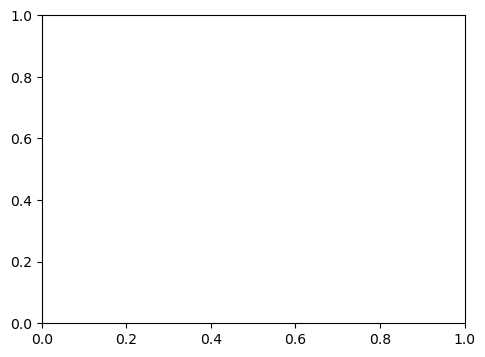

In [69]:
model = RegressionNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 300

for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    # Calculate validation loss
    model.eval()  # Set the model in evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
    
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

print("Training complete")
# Plotting the training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")

Test Loss: 0.8051


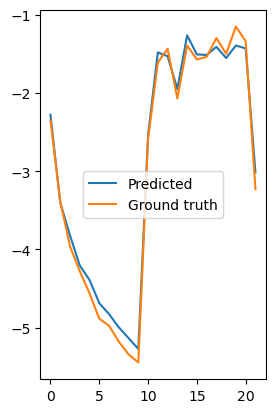

In [76]:
# predict the test data
model.eval()
test_loss = 0.0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")

# Plotting a random output
plt.subplot(1, 2, 2)
random_idx = random.randint(0, len(test_dataset))
data, target = test_dataset[random_idx]
data = data.to(device)
output = model(data)
plt.plot(output.detach().cpu().numpy(), label="Predicted")
plt.plot(target.numpy(), label="Ground truth")  
plt.legend()
plt.show()
plt.close()



